In [1]:
# Background information for the demo:
# https://pythonprogramming.net/forecasting-predicting-machine-learning-tutorial/

# https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install quandl

import quandl

In [2]:
import pandas as pd
import math, datetime
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

In [3]:
quandl.ApiConfig.api_key = 'HMyvtmU7vjSbK5AhTgwi' # use own api_key

In [4]:
# Get stock data
stock = 'EURONEXT/NOKIA'
df = quandl.get(stock, returns='pandas')      # Quandl has pandas dataframe built in
df.tail()

,Open,High,Low,Last,Volume,Turnover
Date,,,,,,
2019-09-19,4.6265,4.7150,4.6170,4.6700,240872.0,1126817.0
2019-09-20,4.6765,4.7955,4.6655,4.7820,411978.0,1942109.0
2019-09-23,4.7920,4.8265,4.6485,4.6700,351038.0,1658852.0
2019-09-24,4.6645,4.6800,4.6415,4.6455,168517.0,783798.0
2019-09-25,4.6020,4.6020,4.4915,4.5700,221235.0,1003718.0


In [5]:
# Create dataframe
df = df[['Open', 'High', 'Low', 'Last', 'Volume', 'Turnover']]
df['VOL_PCT'] = (df['High'] - df['Low']) / df['Last'] * 100.0

df = df[['Open', 'Last', 'Volume', 'VOL_PCT']]

forecast_col = 'Last'

df.fillna(-99999, inplace=True)

pct = 0.05
forecast_out = int(math.ceil(pct*len(df)))      # pct of data set to where forecast is done in days

df['label'] = df[forecast_col].shift(-forecast_out)

X = np.array(df.drop(['label'], 1))  # Features, everything except label
X_lately = X[-forecast_out:]         # Time period to be forecasted 
X = X[:-forecast_out:]

df.dropna(inplace=True)             # Drop missing data

y = np.array(df['label'])           # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)    # Cross-validation

clf = LinearRegression(n_jobs=-1)   # Classifier to be used, n_jobs number of parallel jobs
clf.fit(X_train, y_train)           # Training

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [6]:
print()
last_date = df.iloc[-1].name
print("Last date:", last_date)

confidence = clf.score(X_test, y_test)      # Testing, result squared confidence
print("Confidence: ", round(confidence,4))

forecast_set = clf.predict(X_lately)        # Why not second parameter? - Label is known. (next day)
print("The next stock prices of" ,stock,"for", forecast_out, "days: ")


Last date: 2019-07-17 00:00:00
Confidence:  0.1412
The next stock prices of EURONEXT/NOKIA for 49 days: 


In [7]:
i = 0
# Console printing the forecast stock prices
while i < len(forecast_set):
    if i != 0:
        daily_diff_pct = round((forecast_set[i]-forecast_set[i-1])/(forecast_set[i-1]+forecast_set[i]/2)*100,3)
        daily_diff_lambda = lambda j: ("+" if j > 0 else "") + str(j)
        print("\t", str(np.round(forecast_set[i],3)), "\t", daily_diff_lambda(daily_diff_pct))
    else:
        print("\t", str(np.round(forecast_set[i],3)))
    i += 1

	 4.754
	 4.785 	 +0.439
	 4.752 	 -0.461
	 4.761 	 +0.121
	 4.789 	 +0.403
	 4.898 	 +1.502
	 4.88 	 -0.243
	 4.876 	 -0.063
	 4.843 	 -0.453
	 4.897 	 +0.745
	 4.833 	 -0.876
	 4.821 	 -0.159
	 4.854 	 +0.446
	 4.819 	 -0.484
	 4.842 	 +0.321
	 4.817 	 -0.347
	 4.818 	 +0.019
	 4.858 	 +0.556
	 4.807 	 -0.704
	 4.801 	 -0.092
	 4.777 	 -0.322
	 4.794 	 +0.23
	 4.779 	 -0.206
	 4.782 	 +0.042
	 4.757 	 -0.349
	 4.756 	 -0.014
	 4.74 	 -0.228
	 4.722 	 -0.257
	 4.713 	 -0.117
	 4.737 	 +0.335
	 4.728 	 -0.127
	 4.716 	 -0.168
	 4.722 	 +0.074
	 4.716 	 -0.075
	 4.752 	 +0.507
	 4.742 	 -0.137
	 4.742 	 -0.003
	 4.743 	 +0.014
	 4.762 	 +0.258
	 4.8 	 +0.538
	 4.772 	 -0.385
	 4.764 	 -0.121
	 4.786 	 +0.317
	 4.769 	 -0.246
	 4.804 	 +0.494
	 4.854 	 +0.696
	 4.826 	 -0.392
	 4.764 	 -0.859
	 4.776 	 +0.162


In [8]:
df['Forecast'] = np.nan     # Create empty array

# Populate the forecast set
for i in forecast_set:
    next_date = last_date + datetime.timedelta(days=1)
    df.loc[next_date] = [np.nan for j in range(len(df.columns)-1)] + [i] # [i] adds the item to the set
    last_date = next_date

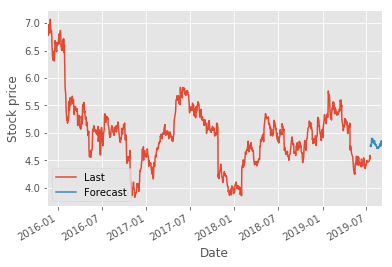

In [9]:
# Plotting the results
df['Last'].plot()
df['Forecast'].plot()
plt.legend(loc=3)
plt.xlabel('Date')
plt.ylabel('Stock price')
plt.show()